In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import skimage
import pydicom
import cv2
from tqdm import tqdm
import sys
from pydicom.pixel_data_handlers.util import apply_modality_lut
import torch
import torch.nn.functional as F

from argparse import Namespace
from pytorch_lightning.utilities.cloud_io import load as pl_load

In [2]:
sys.path.append(os.path.realpath('..'))
from sybilx.datasets.nlst import NLSTCTProjectionsDataset
from sybilx.datasets.nlst_xray import NLST_XRay_Dataset
from sybilx.datasets.plco_xray import PLCO_NLST_Smokers_Dataset, PLCO_XRay_Dataset, PLCO_XRay_Smokers_Dataset
from sybilx.utils.registry import get_object

## Mean Projection

In [3]:
args = Namespace(accelerator=None, accumulate_grad_batches=1, adv_loss_lambda=1.0, adv_lr=0.001, amp_backend='native', amp_level=None, annotation_loss_lambda=1, annotation_loss_lambda_2d=0.04, assign_splits=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, base_model='sybilxray_r50', batch_size=32, benchmark=False, cache_full_img=False, 
                 cache_path=None, callback_names=['checkpointer', 'lr_monitor'], check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_save_last=False, checkpoint_save_top_k=1, class_bal=True, class_bal_key='y', comet_tags=['debug'], cosine_annealing_period=10, cosine_annealing_period_scaling=2, cross_section_filter=None, cross_val_seed=1, data_dir='Data/', dataset='nlst_ct_projections', dataset_file_path='/Mounts/rbg-storage1/datasets/NLST/full_nlst_google.json', default_root_dir=None, detect_anomaly=False, deterministic=False, dev=True, devices=None, distill_aux_loss_lambda=1.0, distill_aux_temperature=1.0, distill_num_subclasses=3, distill_student_loss_lambda=1.0, distill_temperature=1, dropout=0.1, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, eval_loss_fns=None, experiment_name='65a6f7bc526a5065d920a418acd2cbea', fast_dev_run=False, fc_classifier_input_dim=128, filter_derived_images=False, filter_post_processed_images=False, fine_tune=False, finetune_model=None, finetune_model_path=None, fit_to_length=False, fix_multi_image_augmentation_seed=False, fix_seed_for_multi_image_augmentations=True, flush_logs_every_n_steps=None, freeze_encoder_weights=False, from_checkpoint=False, get_dataset_stats=False, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=None, hidden_size=256, hiddens_dir='hiddens/test_run', image_attention_loss_lambda=1, image_side_attention_loss_lambda=1, image_side_attention_loss_lambda_2d=0.035, img_dir='/storage/NLST/nlst-ct-png', img_file_type='dicom', img_mean=[127.2311, 127.2311, 127.2311], img_size=[512, 512], img_std=[74.1043, 74.1043, 74.1043], 
                 input_loader_name='ct_dicom_loader', ipus=None, itrd_alpha=1, itrd_beta_corr=1, itrd_beta_mi=1, lightning_name='base', limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gen_image=False, log_gpu_memory=None, logger=True, logger_name='comet', loss_fns=['cross_entropy', 'guided_attention_2d', 'guided_side_attention_2d'], lr=3e-07, lr_decay=0.1, max_epochs=10, max_followup=6, max_img_height=None, max_img_width=None, max_steps=-1, max_time=None, metrics=['classification'], min_epochs=None, min_img_height=None, min_img_width=None, min_num_images=0, min_steps=None, mlp_input_dim=512, mlp_layer_configuration=[128, 128], mlp_use_batch_norm=False, mlp_use_layer_norm=False, mmd_kernel='guassian_rbf', momentum=0.9, monitor='val_roc_auc', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', multitask_keys=[], multitask_mlp_configuration=[128, 128], multitask_mlp_input_dim=512, nst_lambda=1, num_adv_steps=1, num_chan=3, num_classes=2, num_epochs_fine_tune=1, num_images=200, num_nodes=1, num_processes=1, num_sanity_val_steps=0, num_workers=0, optimizer='adam', overfit_batches=0.0, patience=5, plco_test_study_yrs=None, plco_train_study_yrs=None, plco_use_only_one_image=False, plco_use_only_visitnum=None, plugins=None, precision=16, predict=False, prepare_data_per_node=None, primary_loss_lambda=1.0, process_position=0, profiler=None, progress_bar_refresh_rate=None, proj_encoder_model='sybilxray_r50', project_name='xray-cancer', region_annotations_filepath='/Mounts/rbg-storage1/datasets/NLST/annotations_122020.json', relax_checkpoint_matching=False, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, reset_decoder=False, results_path='/storage/ludvig/logs/65a6f7bc526a5065d920a418acd2cbea', resume_from_checkpoint=None, risk_factor_keys=[], save_attention_scores=False, save_dir='/storage/ludvig/snapshots', save_hiddens=False, save_predictions=False, scale_annotations=False, scheduler='reduce_on_plateau', slice_thickness_filter=None, snapshot=None, split_probs=[0.7, 0.15, 0.15], split_type='random', step_indx=1, stochastic_weight_avg=False, store_classwise_metrics=False, strategy=None, swa_annealing_epochs=10, swa_annealing_strategy='cos', swa_epoch='0.8', swa_lr=None, sync_batchnorm=False, terminate_on_nan=None, test=False, test_projection_rawinput_augmentations=[], test_projection_tnsr_augmentations=[], 
                 test_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {})], 
#                  test_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 test_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 tpu_cores=None, track_grad_norm=-1, train=True, train_projection_rawinput_augmentations=[], train_projection_tnsr_augmentations=[], 
#                  train_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
#                  train_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 train_rawinput_augmentations=[('project_ct', {'method': 'mean', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
                 train_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 treat_ambiguous_as_positive=False, turn_off_checkpointing=False, unix_username='itamar', use_annotations=True, use_faux_binary=False, use_only_thin_cuts_for_ct=True, use_risk_factors=False, val_check_interval=1.0, volume_attention_loss_lambda=1, weight_decay=0.001, weights_save_path=None, weights_summary='top', wfl_alpha=0.9, wfl_gamma=2, with_attention=True, workspace='itamar')

In [4]:
train_data = NLSTCTProjectionsDataset(args, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1587.08it/s]


Contructed NLST CT Cancer Risk train dataset with 30886 records, 30883 exams, 10497 patients, and the following class balance 
 Counter({0: 29316, 1: 1570})
Censor Times: Counter({5: 20174, 4: 7730, 3: 1384, 2: 582, 0: 544, 1: 472})
Class counts are: Counter({0: 29316, 1: 1570})
Label weights are {0: 1.7055532814845137e-05, 1: 0.0003184713375796178}


In [5]:
# dev_data = NLSTCTProjectionsDataset(args, 'dev')
# test_data = NLSTCTProjectionsDataset(args, 'test')

In [6]:
annotations_metadata = json.load(open(args.region_annotations_filepath, "r"))

In [7]:
nlst_meta = json.load(open("/Mounts/rbg-storage1/datasets/NLST/full_nlst_google.json","r"))

In [8]:
sid2paths = {}
exam2sids = {}
for p in tqdm(nlst_meta):
    pid = p['pid']
    for e in p['accessions']:
        for sid, s in e['image_series'].items():
            img_paths = s["paths"]
            img_paths = [ path.replace("/Mounts/rbg-storage1/datasets/NLST/nlst-ct-png", "/storage/NLST/nlst-ct")\
                            .replace(".png", "")
                        for path in img_paths]
            
            slice_locations = s["img_position"]
            
            img_paths = np.array(img_paths).tolist()
            slice_locations = np.array(slice_locations).tolist()
            
            sorted_ids = np.argsort(slice_locations)
            sorted_img_paths = np.array(img_paths)[sorted_ids].tolist()
            
            screen_timepoint = s["series_data"]["study_yr"][0]
            exam_int = int(
                "{}{}{}".format(
                    int(pid), int(screen_timepoint), int(sid.split(".")[-1][-3:])
                )
            )
        
            sid2paths[sid] = sorted_img_paths
            
            if exam_int not in exam2sids:
                exam2sids[exam_int] = []
            exam2sids[exam_int].append(sid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:16<00:00, 905.11it/s]


In [9]:
# examno = exam2sids[1223611685][0]
# sid2paths[examno][0]

## Dataset Stats (Mean projection)

In [12]:
means = []
stds = []
i = 0
for sample in tqdm(train_data):
    if i > 1000:
        break   
    s = sample['x']
    means.append(torch.mean(s[0, :, :]))
    stds.append(torch.std(s[0, :, :]))
    i += 1
    if i % 100 == 0:
        print(np.mean(means), np.mean(stds))

  0%|▎                                                                                                        | 100/30886 [01:06<5:11:34,  1.65it/s]

-682.47064 369.71024


  1%|▋                                                                                                        | 200/30886 [02:14<6:43:57,  1.27it/s]

-690.9255 378.94788


  1%|█                                                                                                        | 300/30886 [03:20<5:46:42,  1.47it/s]

-690.9213 372.80737


  1%|█▎                                                                                                       | 400/30886 [04:23<6:25:19,  1.32it/s]

-683.4295 365.30948


  2%|█▋                                                                                                       | 500/30886 [05:26<5:10:52,  1.63it/s]

-683.06287 364.3256


  2%|██                                                                                                       | 600/30886 [06:38<5:44:53,  1.46it/s]

-685.46173 365.79208


  2%|██▍                                                                                                      | 700/30886 [07:56<5:14:33,  1.60it/s]

-696.29443 375.6104


  3%|██▋                                                                                                      | 800/30886 [09:02<6:11:26,  1.35it/s]

-692.70703 374.58298


  3%|███                                                                                                      | 900/30886 [10:08<6:43:50,  1.24it/s]

-690.3093 373.38535


  3%|███▎                                                                                                    | 1000/30886 [11:17<4:24:33,  1.88it/s]

-691.1225 372.56287


  3%|███▎                                                                                                    | 1001/30886 [11:18<5:37:39,  1.48it/s]


In [13]:
np.mean(means), np.mean(stds)

(-691.3405, 372.76724)

## Campo Projection

In [14]:
args = Namespace(accelerator=None, accumulate_grad_batches=1, adv_loss_lambda=1.0, adv_lr=0.001, amp_backend='native', amp_level=None, annotation_loss_lambda=1, annotation_loss_lambda_2d=0.04, assign_splits=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, base_model='sybilxray_r50', batch_size=32, benchmark=False, cache_full_img=False, 
                 cache_path=None, callback_names=['checkpointer', 'lr_monitor'], check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_save_last=False, checkpoint_save_top_k=1, class_bal=True, class_bal_key='y', comet_tags=['debug'], cosine_annealing_period=10, cosine_annealing_period_scaling=2, cross_section_filter=None, cross_val_seed=1, data_dir='Data/', dataset='nlst_ct_projections', dataset_file_path='/Mounts/rbg-storage1/datasets/NLST/full_nlst_google.json', default_root_dir=None, detect_anomaly=False, deterministic=False, dev=True, devices=None, distill_aux_loss_lambda=1.0, distill_aux_temperature=1.0, distill_num_subclasses=3, distill_student_loss_lambda=1.0, distill_temperature=1, dropout=0.1, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, eval_loss_fns=None, experiment_name='65a6f7bc526a5065d920a418acd2cbea', fast_dev_run=False, fc_classifier_input_dim=128, filter_derived_images=False, filter_post_processed_images=False, fine_tune=False, finetune_model=None, finetune_model_path=None, fit_to_length=False, fix_multi_image_augmentation_seed=False, fix_seed_for_multi_image_augmentations=True, flush_logs_every_n_steps=None, freeze_encoder_weights=False, from_checkpoint=False, get_dataset_stats=False, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=None, hidden_size=256, hiddens_dir='hiddens/test_run', image_attention_loss_lambda=1, image_side_attention_loss_lambda=1, image_side_attention_loss_lambda_2d=0.035, img_dir='/storage/NLST/nlst-ct-png', img_file_type='dicom', img_mean=[127.2311, 127.2311, 127.2311], img_size=[512, 512], img_std=[74.1043, 74.1043, 74.1043], 
                 input_loader_name='ct_dicom_loader', ipus=None, itrd_alpha=1, itrd_beta_corr=1, itrd_beta_mi=1, lightning_name='base', limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gen_image=False, log_gpu_memory=None, logger=True, logger_name='comet', loss_fns=['cross_entropy', 'guided_attention_2d', 'guided_side_attention_2d'], lr=3e-07, lr_decay=0.1, max_epochs=10, max_followup=6, max_img_height=None, max_img_width=None, max_steps=-1, max_time=None, metrics=['classification'], min_epochs=None, min_img_height=None, min_img_width=None, min_num_images=0, min_steps=None, mlp_input_dim=512, mlp_layer_configuration=[128, 128], mlp_use_batch_norm=False, mlp_use_layer_norm=False, mmd_kernel='guassian_rbf', momentum=0.9, monitor='val_roc_auc', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', multitask_keys=[], multitask_mlp_configuration=[128, 128], multitask_mlp_input_dim=512, nst_lambda=1, num_adv_steps=1, num_chan=3, num_classes=2, num_epochs_fine_tune=1, num_images=200, num_nodes=1, num_processes=1, num_sanity_val_steps=0, num_workers=0, optimizer='adam', overfit_batches=0.0, patience=5, plco_test_study_yrs=None, plco_train_study_yrs=None, plco_use_only_one_image=False, plco_use_only_visitnum=None, plugins=None, precision=16, predict=False, prepare_data_per_node=None, primary_loss_lambda=1.0, process_position=0, profiler=None, progress_bar_refresh_rate=None, proj_encoder_model='sybilxray_r50', project_name='xray-cancer', region_annotations_filepath='/Mounts/rbg-storage1/datasets/NLST/annotations_122020.json', relax_checkpoint_matching=False, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, reset_decoder=False, results_path='/storage/ludvig/logs/65a6f7bc526a5065d920a418acd2cbea', resume_from_checkpoint=None, risk_factor_keys=[], save_attention_scores=False, save_dir='/storage/ludvig/snapshots', save_hiddens=False, save_predictions=False, scale_annotations=False, scheduler='reduce_on_plateau', slice_thickness_filter=None, snapshot=None, split_probs=[0.7, 0.15, 0.15], split_type='random', step_indx=1, stochastic_weight_avg=False, store_classwise_metrics=False, strategy=None, swa_annealing_epochs=10, swa_annealing_strategy='cos', swa_epoch='0.8', swa_lr=None, sync_batchnorm=False, terminate_on_nan=None, test=False, test_projection_rawinput_augmentations=[], test_projection_tnsr_augmentations=[], 
                 test_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {})], 
#                  test_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 test_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 tpu_cores=None, track_grad_norm=-1, train=True, train_projection_rawinput_augmentations=[], train_projection_tnsr_augmentations=[], 
                 train_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
#                  train_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 train_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 treat_ambiguous_as_positive=False, turn_off_checkpointing=False, unix_username='itamar', use_annotations=True, use_faux_binary=False, use_only_thin_cuts_for_ct=True, use_risk_factors=False, val_check_interval=1.0, volume_attention_loss_lambda=1, weight_decay=0.001, weights_save_path=None, weights_summary='top', wfl_alpha=0.9, wfl_gamma=2, with_attention=True, workspace='itamar')

In [15]:
train_data = NLSTCTProjectionsDataset(args, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1510.71it/s]


Contructed NLST CT Cancer Risk train dataset with 30886 records, 30883 exams, 10497 patients, and the following class balance 
 Counter({0: 29316, 1: 1570})
Censor Times: Counter({5: 20174, 4: 7730, 3: 1384, 2: 582, 0: 544, 1: 472})
Class counts are: Counter({0: 29316, 1: 1570})
Label weights are {0: 1.7055532814845137e-05, 1: 0.0003184713375796178}


In [16]:
# dev_data = NLSTCTProjectionsDataset(args, 'dev')
# test_data = NLSTCTProjectionsDataset(args, 'test')

In [17]:
annotations_metadata = json.load(open(args.region_annotations_filepath, "r"))

In [18]:
nlst_meta = json.load(open("/Mounts/rbg-storage1/datasets/NLST/full_nlst_google.json","r"))

In [19]:
sid2paths = {}
exam2sids = {}
for p in tqdm(nlst_meta):
    pid = p['pid']
    for e in p['accessions']:
        for sid, s in e['image_series'].items():
            img_paths = s["paths"]
            img_paths = [ path.replace("/Mounts/rbg-storage1/datasets/NLST/nlst-ct-png", "/storage/NLST/nlst-ct")\
                            .replace(".png", "")
                        for path in img_paths]
            
            slice_locations = s["img_position"]
            
            img_paths = np.array(img_paths).tolist()
            slice_locations = np.array(slice_locations).tolist()
            
            sorted_ids = np.argsort(slice_locations)
            sorted_img_paths = np.array(img_paths)[sorted_ids].tolist()
            
            screen_timepoint = s["series_data"]["study_yr"][0]
            exam_int = int(
                "{}{}{}".format(
                    int(pid), int(screen_timepoint), int(sid.split(".")[-1][-3:])
                )
            )
        
            sid2paths[sid] = sorted_img_paths
            
            if exam_int not in exam2sids:
                exam2sids[exam_int] = []
            exam2sids[exam_int].append(sid)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:21<00:00, 700.42it/s]


## Dataset Stats (Campo)

In [20]:
means = []
stds = []
i = 0
for sample in tqdm(train_data):
    if i > 1000:
        break   
    s = sample['x']
    means.append(torch.mean(s[0, :, :]))
    stds.append(torch.std(s[0, :, :]))
    i += 1
    if i % 100 == 0:
        print(np.mean(means), np.mean(stds))

  0%|▎                                                                                                       | 100/30886 [02:23<10:08:42,  1.19s/it]

1.7386267 0.26810172


  1%|▋                                                                                                       | 200/30886 [04:30<14:09:19,  1.66s/it]

153.444 21179.346


  1%|█                                                                                                       | 300/30886 [06:41<11:47:48,  1.39s/it]

102.8693 14119.648


  1%|█▎                                                                                                      | 400/30886 [08:45<11:28:44,  1.36s/it]

77.58448 10589.804


  2%|█▋                                                                                                       | 500/30886 [10:44<9:40:17,  1.15s/it]

62.412975 8471.895


  2%|██                                                                                                      | 600/30886 [12:54<10:05:16,  1.20s/it]

52.29888 7060.0366


  2%|██▍                                                                                                      | 700/30886 [15:15<9:41:42,  1.16s/it]

45.073433 6051.498


  3%|██▋                                                                                                     | 800/30886 [17:18<10:31:04,  1.26s/it]

282.0762 44200.31


  3%|███                                                                                                     | 900/30886 [19:19<12:21:39,  1.48s/it]

250.99551 39301.555


  3%|███▎                                                                                                    | 1000/30886 [21:38<8:51:26,  1.07s/it]

227.35637 35386.984


  3%|███▎                                                                                                   | 1001/30886 [21:40<10:47:00,  1.30s/it]


In [21]:
np.mean(means), np.mean(stds)

(227.13098, 35351.633)

# 1. Viewing Sample Image and its projection

In [ ]:
# chooses the first sample with an annotation
chosen_sample = None
for i in range(0, len(train_data.dataset)):
    s = train_data.dataset[i]
    has_annotations = s['series'] in annotations_metadata
    if not s['y'] or not has_annotations:
        continue

    # uncomment to select only one lung side
#     right, left, other = s["cancer_laterality"]
#     if not left:
#         continue
    
    chosen_sample = train_data[i]
    break

print("Chosen sample idx =", i)
chosen_sample.keys()

In [12]:
# right, left, other = chosen_sample["cancer_laterality"]
# print(f"right = {right}")
# print(f"left = {left}")
# print(f"other = {other}")

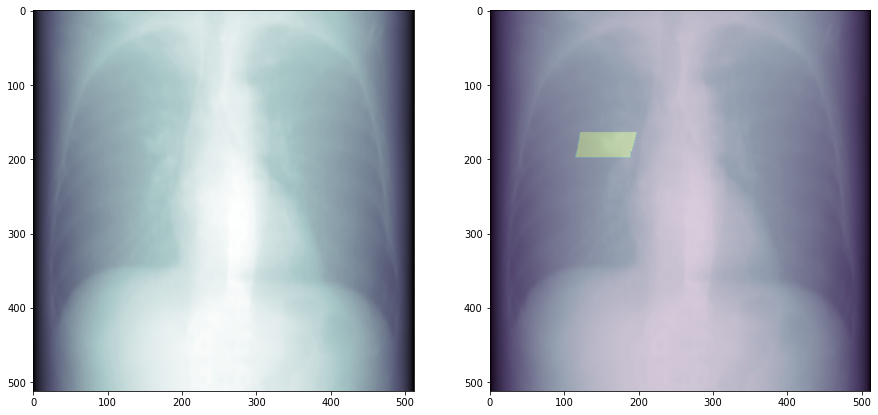

In [13]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,15))

img = chosen_sample['x'][0]
ann = chosen_sample["projection_image_annotations"][0]

ax0.imshow(img, cmap=plt.cm.bone)
ax1.imshow(img, cmap=plt.cm.bone)
ax1.imshow(ann, alpha=0.2)

In [14]:
img.min(), img.max()

(tensor(-2848.1504), tensor(-12.8707))

Showing the CT scan:

In [45]:
i = 0
truths = []
for paths in tqdm(sid2paths.values()):
    i += 1 
    if i > 1000:
        break
    for slice_i in range(0, len(paths), 1):
        import copy
        path = paths[slice_i]
        dcm = pydicom.dcmread(path)
        xx = copy.deepcopy(dcm.pixel_array)
        truths.append(np.all(img == xx))

any(truths)

  0%|                                                                                                          | 1/126027 [00:00<6:47:30,  5.15it/s]/tmp/ipykernel_37942/934362378.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  truths.append(np.all(img == xx))
  1%|▊                                                                                                      | 1000/126027 [03:34<7:27:42,  4.65it/s]


False

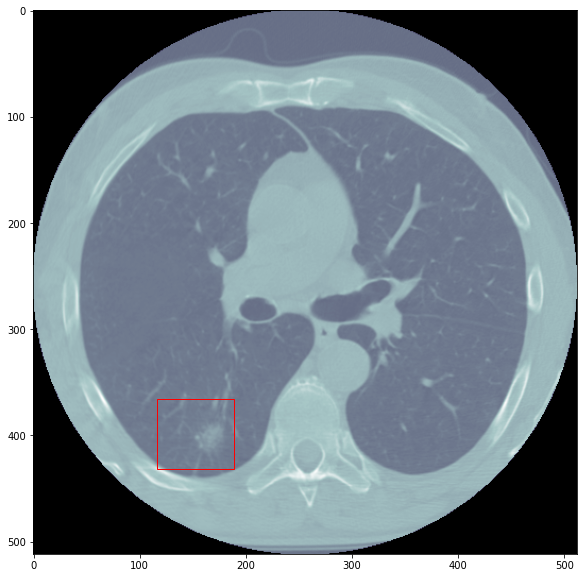

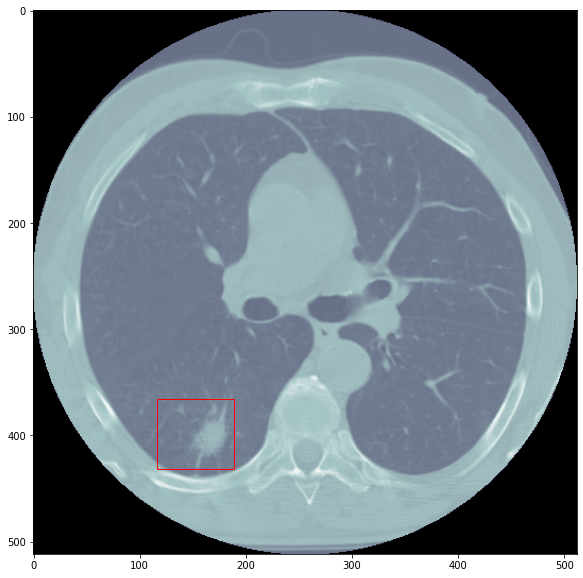

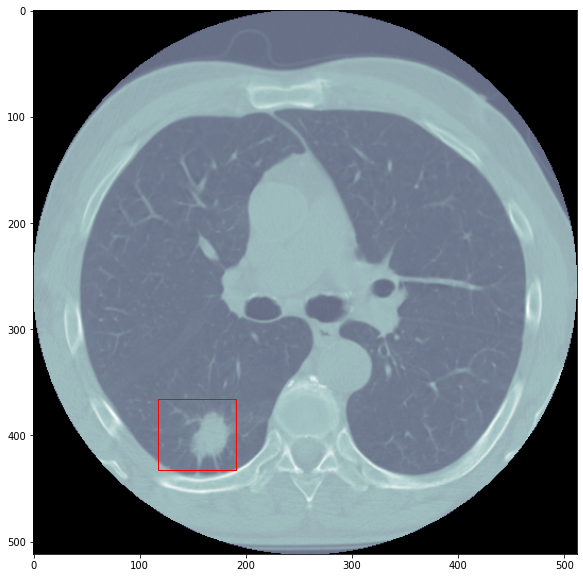

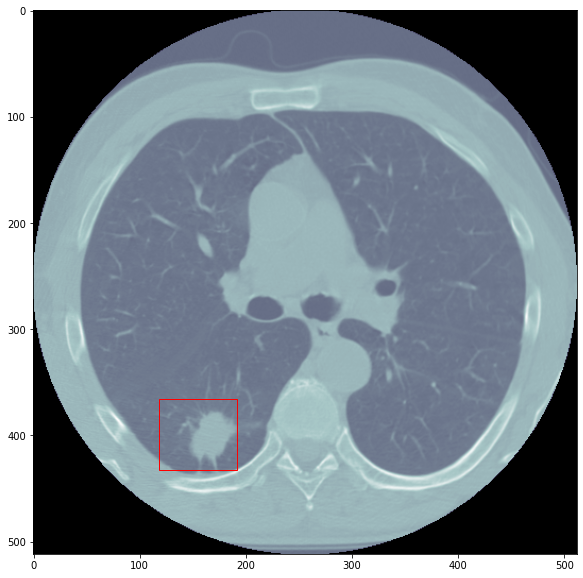

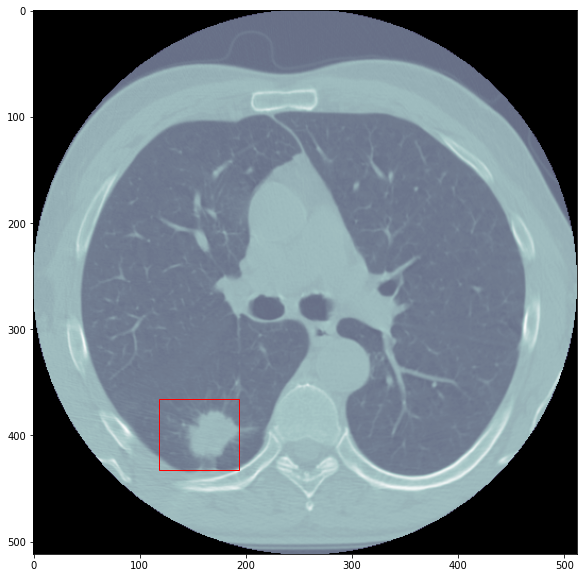

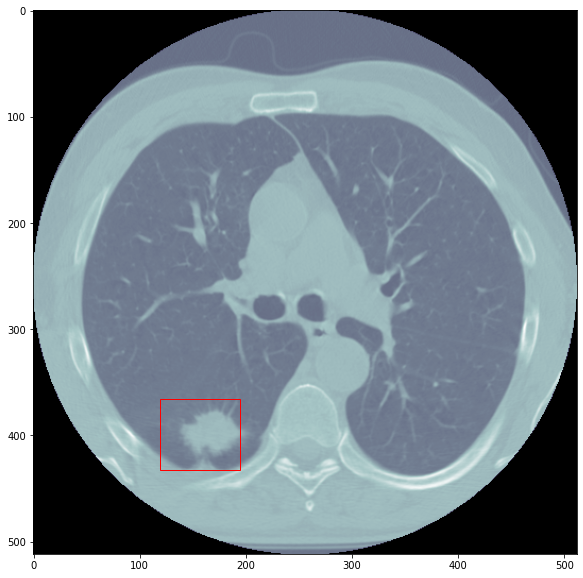

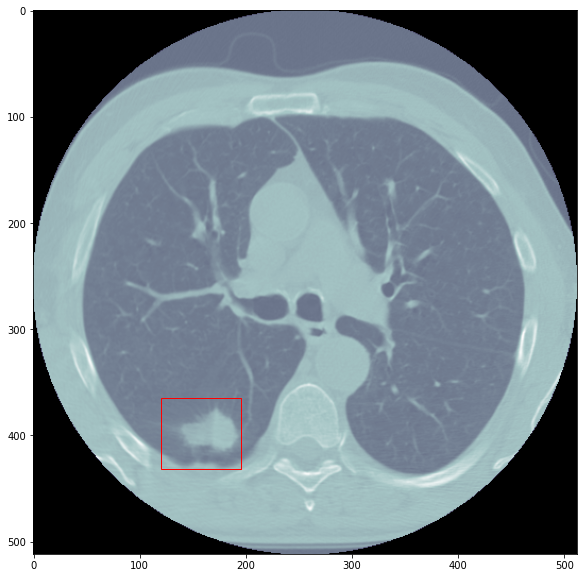

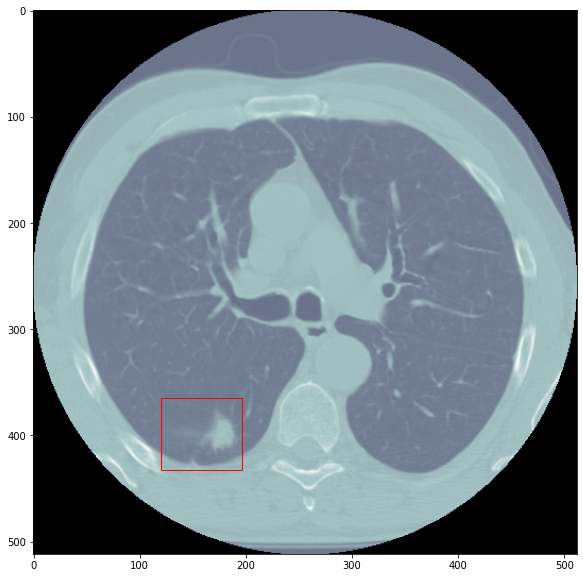

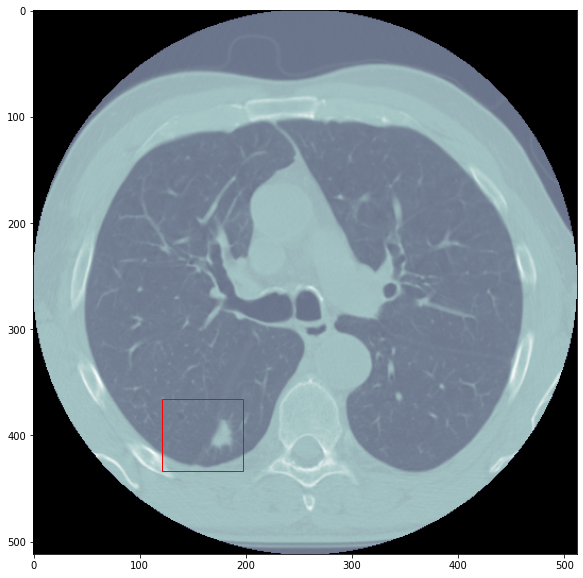

In [30]:
paths = sid2paths[chosen_sample["series"]]
anns = annotations_metadata[chosen_sample["series"]]
mins, maxs, means = [], [], []

        
for slice_i in range(0, len(paths), 1):
    path = paths[slice_i]
    dcm = pydicom.dcmread(path)
    
    img = apply_modality_lut(dcm.pixel_array, dcm)
    
#     plt.figure(figsize=(10,10))
    if os.path.basename(path) in anns:
        plt.figure(figsize=(10,10))
        plt.imshow(img, cmap=plt.cm.bone)
        for ann in anns[os.path.basename(path)]:
            x = ann["x"]*img.shape[1]
            y = ann["y"]*img.shape[0]
            width = ann["width"]*img.shape[1]
            height = ann["height"]*img.shape[0]
            ax = plt.gca()
            rect = plt.Rectangle(xy=(x,y), width=width, height=height, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
    # uncomment to show all slices
#     plt.imshow(img, cmap=plt.cm.bone)

    mins.append(img.min())
    maxs.append(img.max())
    means.append(img.mean())

In [22]:
len(mins) # , maxs, means

135

In [24]:
np.mean(mins), np.mean(maxs), np.mean(means)

(-3024.0, 1350.9037037037037, -894.9105606644242)

In [26]:
np.min(mins), np.max(maxs), np.mean(means)

(-3024.0, 1733.0, -894.9105606644242)

## Number of Regular PLCO Patients

In [80]:
args = Namespace(accelerator=None, accumulate_grad_batches=1, adv_loss_lambda=1.0, adv_lr=0.001, amp_backend='native', amp_level=None, annotation_loss_lambda=1, annotation_loss_lambda_2d=0.04, 
                 assign_splits=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, 
                 base_model='simple_sybilx_r50', batch_size=32, benchmark=False, cache_full_img=False, 
                 cache_path="/storage/xray_cache", callback_names=['checkpointer', 'lr_monitor'], check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_save_last=False, checkpoint_save_top_k=1, class_bal=True, class_bal_key='y', 
                 comet_tags=['debug'], cosine_annealing_period=10, cosine_annealing_period_scaling=2, cross_section_filter=None, cross_val_seed=1, 
                 data_dir='Data/', 
                 dataset='plco_xray', 
                 dataset_file_path="/storage/ludvig/PLCO_XRAY/metadata_2022_04_05_rotated.json", default_root_dir=None, detect_anomaly=False, deterministic=False, dev=True, devices=None, distill_aux_loss_lambda=1.0, distill_aux_temperature=1.0, distill_num_subclasses=3, distill_student_loss_lambda=1.0, distill_temperature=1, dropout=0.1, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, eval_loss_fns=None, experiment_name='65a6f7bc526a5065d920a418acd2cbea', fast_dev_run=False, fc_classifier_input_dim=128, filter_derived_images=False, filter_post_processed_images=False, fine_tune=False, finetune_model=None, finetune_model_path=None, fit_to_length=False, fix_multi_image_augmentation_seed=False, fix_seed_for_multi_image_augmentations=True, flush_logs_every_n_steps=None, freeze_encoder_weights=False, from_checkpoint=False, get_dataset_stats=False, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=None, hidden_size=256, hiddens_dir='hiddens/test_run', image_attention_loss_lambda=1, image_side_attention_loss_lambda=1, image_side_attention_loss_lambda_2d=0.035, 
                 img_mean=[127.2311, 127.2311, 127.2311], 
                 img_size=[512, 512], 
                 img_std=[74.1043, 74.1043, 74.1043], 
                 input_loader_name='tif_loader', ipus=None, itrd_alpha=1, itrd_beta_corr=1, itrd_beta_mi=1, lightning_name='base', limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gen_image=False, log_gpu_memory=None, logger=True, logger_name='comet', 
                 loss_fns=['cross_entropy', 'guided_attention_2d'], lr=3e-07, lr_decay=0.1, max_epochs=10, max_followup=6, max_img_height=None, max_img_width=None, max_steps=-1, max_time=None, metrics=['classification'], min_epochs=None, min_img_height=None, min_img_width=None, min_num_images=0, min_steps=None, mlp_input_dim=512, mlp_layer_configuration=[128, 128], mlp_use_batch_norm=False, mlp_use_layer_norm=False, mmd_kernel='guassian_rbf', momentum=0.9, monitor='val_roc_auc', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', multitask_keys=[], multitask_mlp_configuration=[128, 128], multitask_mlp_input_dim=512, nst_lambda=1, num_adv_steps=1, num_chan=3, num_classes=2, num_epochs_fine_tune=1, num_images=200, num_nodes=1, num_processes=1, num_sanity_val_steps=0, num_workers=0, optimizer='adam', overfit_batches=0.0, patience=5, plco_test_study_yrs=None, plco_train_study_yrs=None, plco_use_only_one_image=False, plco_use_only_visitnum=None, plugins=None, precision=16, predict=False, prepare_data_per_node=None, primary_loss_lambda=1.0, process_position=0, profiler=None, progress_bar_refresh_rate=None, proj_encoder_model='sybilxray_r50', project_name='xray-cancer', 
                 region_annotations_filepath='/Mounts/rbg-storage1/datasets/NLST/annotations_122020.json', relax_checkpoint_matching=False, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, reset_decoder=False, results_path='/storage/ludvig/logs/65a6f7bc526a5065d920a418acd2cbea', resume_from_checkpoint=None, risk_factor_keys=[], save_attention_scores=False, save_dir='/storage/ludvig/snapshots', save_hiddens=False, save_predictions=False, scale_annotations=False, scheduler='reduce_on_plateau', slice_thickness_filter=None, snapshot=None, split_probs=[0.7, 0.15, 0.15], split_type='random', step_indx=1, stochastic_weight_avg=False, store_classwise_metrics=False, strategy=None, swa_annealing_epochs=10, swa_annealing_strategy='cos', swa_epoch='0.8', swa_lr=None, sync_batchnorm=False, terminate_on_nan=None, test=False, test_projection_rawinput_augmentations=[], test_projection_tnsr_augmentations=[], 
                 test_rawinput_augmentations=[('scale_2d', {})], 
#                  test_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 test_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 tpu_cores=None, track_grad_norm=-1, train=True, train_projection_rawinput_augmentations=[], train_projection_tnsr_augmentations=[], 
#                  train_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
#                  train_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 train_rawinput_augmentations=[('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
                 train_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 treat_ambiguous_as_positive=False, turn_off_checkpointing=False, unix_username='itamar', 
                 use_annotations=False, use_faux_binary=False, use_only_thin_cuts_for_ct=True, 
                 use_risk_factors=True, val_check_interval=1.0, volume_attention_loss_lambda=1, weight_decay=0.001, weights_save_path=None, weights_summary='top', wfl_alpha=0.9, wfl_gamma=2, with_attention=True, workspace='itamar')

In [81]:
train_data = PLCO_XRay_Dataset(args, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 17315.51it/s]

Contructed PLCO X-Ray Cancer Risk train dataset with 62608 records, 58767 exams, 17441 patients, and the following class balance 
 Counter({0: 61167, 1: 1441})
Censor Times: Counter({5: 58491, 4: 923, 3: 907, 2: 867, 1: 751, 0: 669})
Class counts are: Counter({0: 61167, 1: 1441})
Label weights are {0: 8.174342374155998e-06, 1: 0.00034698126301179735}


In [82]:
dev_data = PLCO_XRay_Dataset(args, 'dev')
test_data = PLCO_XRay_Dataset(args, 'test')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 75544.73it/s]


Contructed PLCO X-Ray Cancer Risk dev dataset with 13638 records, 12755 exams, 3802 patients, and the following class balance 
 Counter({0: 13348, 1: 290})
Censor Times: Counter({5: 12809, 4: 186, 2: 179, 3: 174, 1: 162, 0: 128})
Class counts are: Counter({0: 13348, 1: 290})
Label weights are {0: 3.7458795325142346e-05, 1: 0.0017241379310344827}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 73065.44it/s]

Contructed PLCO X-Ray Cancer Risk test dataset with 13416 records, 12580 exams, 3727 patients, and the following class balance 
 Counter({0: 13129, 1: 287})
Censor Times: Counter({5: 12569, 2: 193, 3: 178, 4: 173, 1: 161, 0: 142})
Class counts are: Counter({0: 13129, 1: 287})
Label weights are {0: 3.8083631655114635e-05, 1: 0.0017421602787456446}


## Number of NLST smokers in PLCO dataset

In [83]:
args = Namespace(accelerator=None, accumulate_grad_batches=1, adv_loss_lambda=1.0, adv_lr=0.001, amp_backend='native', amp_level=None, annotation_loss_lambda=1, annotation_loss_lambda_2d=0.04, 
                 assign_splits=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, 
                 base_model='simple_sybilx_r50', batch_size=32, benchmark=False, cache_full_img=False, 
                 cache_path="/storage/xray_cache", callback_names=['checkpointer', 'lr_monitor'], check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_save_last=False, checkpoint_save_top_k=1, class_bal=True, class_bal_key='y', 
                 comet_tags=['debug'], cosine_annealing_period=10, cosine_annealing_period_scaling=2, cross_section_filter=None, cross_val_seed=1, 
                 data_dir='Data/', 
                 dataset='plco_nlst_smokers', 
                 dataset_file_path="/storage/ludvig/PLCO_XRAY/metadata_2022_04_05_rotated.json", default_root_dir=None, detect_anomaly=False, deterministic=False, dev=True, devices=None, distill_aux_loss_lambda=1.0, distill_aux_temperature=1.0, distill_num_subclasses=3, distill_student_loss_lambda=1.0, distill_temperature=1, dropout=0.1, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, eval_loss_fns=None, experiment_name='65a6f7bc526a5065d920a418acd2cbea', fast_dev_run=False, fc_classifier_input_dim=128, filter_derived_images=False, filter_post_processed_images=False, fine_tune=False, finetune_model=None, finetune_model_path=None, fit_to_length=False, fix_multi_image_augmentation_seed=False, fix_seed_for_multi_image_augmentations=True, flush_logs_every_n_steps=None, freeze_encoder_weights=False, from_checkpoint=False, get_dataset_stats=False, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=None, hidden_size=256, hiddens_dir='hiddens/test_run', image_attention_loss_lambda=1, image_side_attention_loss_lambda=1, image_side_attention_loss_lambda_2d=0.035, 
                 img_mean=[127.2311, 127.2311, 127.2311], 
                 img_size=[512, 512], 
                 img_std=[74.1043, 74.1043, 74.1043], 
                 input_loader_name='tif_loader', ipus=None, itrd_alpha=1, itrd_beta_corr=1, itrd_beta_mi=1, lightning_name='base', limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gen_image=False, log_gpu_memory=None, logger=True, logger_name='comet', 
                 loss_fns=['cross_entropy', 'guided_attention_2d'], lr=3e-07, lr_decay=0.1, max_epochs=10, max_followup=6, max_img_height=None, max_img_width=None, max_steps=-1, max_time=None, metrics=['classification'], min_epochs=None, min_img_height=None, min_img_width=None, min_num_images=0, min_steps=None, mlp_input_dim=512, mlp_layer_configuration=[128, 128], mlp_use_batch_norm=False, mlp_use_layer_norm=False, mmd_kernel='guassian_rbf', momentum=0.9, monitor='val_roc_auc', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', multitask_keys=[], multitask_mlp_configuration=[128, 128], multitask_mlp_input_dim=512, nst_lambda=1, num_adv_steps=1, num_chan=3, num_classes=2, num_epochs_fine_tune=1, num_images=200, num_nodes=1, num_processes=1, num_sanity_val_steps=0, num_workers=0, optimizer='adam', overfit_batches=0.0, patience=5, plco_test_study_yrs=None, plco_train_study_yrs=None, plco_use_only_one_image=False, plco_use_only_visitnum=None, plugins=None, precision=16, predict=False, prepare_data_per_node=None, primary_loss_lambda=1.0, process_position=0, profiler=None, progress_bar_refresh_rate=None, proj_encoder_model='sybilxray_r50', project_name='xray-cancer', 
                 region_annotations_filepath='/Mounts/rbg-storage1/datasets/NLST/annotations_122020.json', relax_checkpoint_matching=False, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, reset_decoder=False, results_path='/storage/ludvig/logs/65a6f7bc526a5065d920a418acd2cbea', resume_from_checkpoint=None, risk_factor_keys=[], save_attention_scores=False, save_dir='/storage/ludvig/snapshots', save_hiddens=False, save_predictions=False, scale_annotations=False, scheduler='reduce_on_plateau', slice_thickness_filter=None, snapshot=None, split_probs=[0.7, 0.15, 0.15], split_type='random', step_indx=1, stochastic_weight_avg=False, store_classwise_metrics=False, strategy=None, swa_annealing_epochs=10, swa_annealing_strategy='cos', swa_epoch='0.8', swa_lr=None, sync_batchnorm=False, terminate_on_nan=None, test=False, test_projection_rawinput_augmentations=[], test_projection_tnsr_augmentations=[], 
                 test_rawinput_augmentations=[('scale_2d', {})], 
#                  test_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 test_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 tpu_cores=None, track_grad_norm=-1, train=True, train_projection_rawinput_augmentations=[], train_projection_tnsr_augmentations=[], 
#                  train_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
#                  train_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 train_rawinput_augmentations=[('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
                 train_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 treat_ambiguous_as_positive=False, turn_off_checkpointing=False, unix_username='itamar', 
                 use_annotations=False, use_faux_binary=False, use_only_thin_cuts_for_ct=True, 
                 use_risk_factors=True, val_check_interval=1.0, volume_attention_loss_lambda=1, weight_decay=0.001, weights_save_path=None, weights_summary='top', wfl_alpha=0.9, wfl_gamma=2, with_attention=True, workspace='itamar')

In [84]:
train_data = PLCO_NLST_Smokers_Dataset(args, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:01<00:00, 19783.22it/s]


Contructed PLCO X-Ray Cancer Risk train dataset with 48938 records, 46056 exams, 14004 patients, and the following class balance 
 Counter({0: 48410, 1: 528})
Censor Times: Counter({5: 46450, 3: 581, 4: 579, 2: 520, 1: 441, 0: 367})
Class counts are: Counter({0: 48410, 1: 528})
Label weights are {0: 1.032844453625284e-05, 1: 0.000946969696969697}


In [85]:
dev_data = PLCO_NLST_Smokers_Dataset(args, 'dev')
test_data = PLCO_NLST_Smokers_Dataset(args, 'test')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 87602.31it/s]


Contructed PLCO X-Ray Cancer Risk dev dataset with 10704 records, 10075 exams, 3068 patients, and the following class balance 
 Counter({0: 10593, 1: 111})
Censor Times: Counter({5: 10241, 2: 110, 4: 110, 3: 99, 1: 85, 0: 59})
Class counts are: Counter({0: 10593, 1: 111})
Label weights are {0: 4.7200981780421035e-05, 1: 0.0045045045045045045}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 85839.23it/s]

Contructed PLCO X-Ray Cancer Risk test dataset with 10490 records, 9903 exams, 3004 patients, and the following class balance 
 Counter({0: 10372, 1: 118})
Censor Times: Counter({5: 10012, 4: 107, 2: 105, 3: 101, 1: 90, 0: 75})
Class counts are: Counter({0: 10372, 1: 118})
Label weights are {0: 4.820671037408407e-05, 1: 0.00423728813559322}


## PLCO Non-NLST Smokers

In [3]:
args = Namespace(accelerator=None, accumulate_grad_batches=1, adv_loss_lambda=1.0, adv_lr=0.001, amp_backend='native', amp_level=None, annotation_loss_lambda=1, annotation_loss_lambda_2d=0.04, 
                 assign_splits=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, 
                 base_model='simple_sybilx_r50', batch_size=32, benchmark=False, cache_full_img=False, 
                 cache_path="/storage/xray_cache", callback_names=['checkpointer', 'lr_monitor'], check_val_every_n_epoch=1, checkpoint_callback=None, checkpoint_save_last=False, checkpoint_save_top_k=1, class_bal=True, class_bal_key='y', 
                 comet_tags=['debug'], cosine_annealing_period=10, cosine_annealing_period_scaling=2, cross_section_filter=None, cross_val_seed=1, 
                 data_dir='Data/', 
                 dataset='plco_xray_smokers', 
                 dataset_file_path="/storage/ludvig/PLCO_XRAY/metadata_2022_04_05_rotated.json", default_root_dir=None, detect_anomaly=False, deterministic=False, dev=True, devices=None, distill_aux_loss_lambda=1.0, distill_aux_temperature=1.0, distill_num_subclasses=3, distill_student_loss_lambda=1.0, distill_temperature=1, dropout=0.1, enable_checkpointing=True, enable_model_summary=True, enable_progress_bar=True, eval_loss_fns=None, experiment_name='65a6f7bc526a5065d920a418acd2cbea', fast_dev_run=False, fc_classifier_input_dim=128, filter_derived_images=False, filter_post_processed_images=False, fine_tune=False, finetune_model=None, finetune_model_path=None, fit_to_length=False, fix_multi_image_augmentation_seed=False, fix_seed_for_multi_image_augmentations=True, flush_logs_every_n_steps=None, freeze_encoder_weights=False, from_checkpoint=False, get_dataset_stats=False, gpus=1, gradient_clip_algorithm=None, gradient_clip_val=None, hidden_size=256, hiddens_dir='hiddens/test_run', image_attention_loss_lambda=1, image_side_attention_loss_lambda=1, image_side_attention_loss_lambda_2d=0.035, 
                 img_mean=[127.2311, 127.2311, 127.2311], 
                 img_size=[512, 512], 
                 img_std=[74.1043, 74.1043, 74.1043], 
                 input_loader_name='tif_loader', ipus=None, itrd_alpha=1, itrd_beta_corr=1, itrd_beta_mi=1, lightning_name='base', limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_val_batches=1.0, log_every_n_steps=50, log_gen_image=False, log_gpu_memory=None, logger=True, logger_name='comet', 
                 loss_fns=['cross_entropy', 'guided_attention_2d'], lr=3e-07, lr_decay=0.1, max_epochs=10, max_followup=6, max_img_height=None, max_img_width=None, max_steps=-1, max_time=None, metrics=['classification'], min_epochs=None, min_img_height=None, min_img_width=None, min_num_images=0, min_steps=None, mlp_input_dim=512, mlp_layer_configuration=[128, 128], mlp_use_batch_norm=False, mlp_use_layer_norm=False, mmd_kernel='guassian_rbf', momentum=0.9, monitor='val_roc_auc', move_metrics_to_cpu=False, multiple_trainloader_mode='max_size_cycle', multitask_keys=[], multitask_mlp_configuration=[128, 128], multitask_mlp_input_dim=512, nst_lambda=1, num_adv_steps=1, num_chan=3, num_classes=2, num_epochs_fine_tune=1, num_images=200, num_nodes=1, num_processes=1, num_sanity_val_steps=0, num_workers=0, optimizer='adam', overfit_batches=0.0, patience=5, plco_test_study_yrs=None, plco_train_study_yrs=None, plco_use_only_one_image=False, plco_use_only_visitnum=None, plugins=None, precision=16, predict=False, prepare_data_per_node=None, primary_loss_lambda=1.0, process_position=0, profiler=None, progress_bar_refresh_rate=None, proj_encoder_model='sybilxray_r50', project_name='xray-cancer', 
                 region_annotations_filepath='/Mounts/rbg-storage1/datasets/NLST/annotations_122020.json', relax_checkpoint_matching=False, reload_dataloaders_every_epoch=False, reload_dataloaders_every_n_epochs=0, replace_sampler_ddp=False, reset_decoder=False, results_path='/storage/ludvig/logs/65a6f7bc526a5065d920a418acd2cbea', resume_from_checkpoint=None, risk_factor_keys=[], save_attention_scores=False, save_dir='/storage/ludvig/snapshots', save_hiddens=False, save_predictions=False, scale_annotations=False, scheduler='reduce_on_plateau', slice_thickness_filter=None, snapshot=None, split_probs=[0.7, 0.15, 0.15], split_type='random', step_indx=1, stochastic_weight_avg=False, store_classwise_metrics=False, strategy=None, swa_annealing_epochs=10, swa_annealing_strategy='cos', swa_epoch='0.8', swa_lr=None, sync_batchnorm=False, terminate_on_nan=None, test=False, test_projection_rawinput_augmentations=[], test_projection_tnsr_augmentations=[], 
                 test_rawinput_augmentations=[('scale_2d', {})], 
#                  test_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 test_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 tpu_cores=None, track_grad_norm=-1, train=True, train_projection_rawinput_augmentations=[], train_projection_tnsr_augmentations=[], 
#                  train_rawinput_augmentations=[('project_ct', {'method': 'campo', 'annotation_method': 'max-threshold'}), ('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
#                  train_tnsr_augmentations=[('force_num_chan_2d', {}), ('normalize_2d', {})], 
                 train_rawinput_augmentations=[('scale_2d', {}), ('rotate_range', {'deg': 20.0})], 
                 train_tnsr_augmentations=[('force_num_chan_2d', {})], 
                 treat_ambiguous_as_positive=False, turn_off_checkpointing=False, unix_username='itamar', 
                 use_annotations=False, use_faux_binary=False, use_only_thin_cuts_for_ct=True, 
                 use_risk_factors=True, val_check_interval=1.0, volume_attention_loss_lambda=1, weight_decay=0.001, weights_save_path=None, weights_summary='top', wfl_alpha=0.9, wfl_gamma=2, with_attention=True, workspace='itamar')

In [4]:
train_data = PLCO_XRay_Smokers_Dataset(args, 'train')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 95729.33it/s]

Contructed PLCO X-Ray Cancer Risk train dataset with 7558 records, 7008 exams, 2045 patients, and the following class balance 
 Counter({0: 6996, 1: 562})
Censor Times: Counter({5: 6558, 4: 226, 3: 203, 2: 201, 0: 188, 1: 182})
Class counts are: Counter({0: 6996, 1: 562})
Label weights are {0: 7.14694110920526e-05, 1: 0.0008896797153024911}


In [5]:
train_data.dataset[0].keys()

dict_keys(['path', 'y', 'time_at_event', 'y_seq', 'y_mask', 'exam_str', 'exam', 'accession', 'series', 'screen_timepoint', 'pid', 'risk_factors'])

In [6]:
sample = train_data.dataset[0]

In [7]:
# "age": current_age,
# "is_smoker": is_smoker,
# "is_NLST_smoker": is_NLST_smoker,
# "is_not_smoker": is_not_smoker, # don't judge, this is to be true to CXR-LC paper
# "smoking_status_unknown": smoking_status_unknown,
# "smoking_duration": years_smoking,
# "years_since_quit_smoking": years_since_quit_smoking,
# "is_female": int(pt_metadata["sex"] == 0),
# "is_male": int(pt_metadata["sex"] == 1),
# "gender_unknown": int(pt_metadata["sex"] == -1)
sample['risk_factors']

array([57.,  1.,  0.,  0.,  0., 33.,  0.,  0.,  1.,  0.])

In [77]:
sample['series']

'AD02485080607140559_v2.tif'

In [78]:
sample['exam']

6901101140

In [79]:
sample['accession']

0

In [54]:
dev_data = PLCO_XRay_Smokers_Dataset(args, 'dev')
test_data = PLCO_XRay_Smokers_Dataset(args, 'test')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 116156.36it/s]


Contructed PLCO X-Ray Cancer Risk dev dataset with 11920 records, 11184 exams, 3333 patients, and the following class balance 
 Counter({0: 11768, 1: 152})
Censor Times: Counter({5: 11350, 2: 131, 4: 128, 3: 127, 1: 103, 0: 81})
Class counts are: Counter({0: 11768, 1: 152})
Label weights are {0: 4.24881033310673e-05, 1: 0.003289473684210526}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:00<00:00, 114457.49it/s]

Contructed PLCO X-Ray Cancer Risk test dataset with 11765 records, 11076 exams, 3298 patients, and the following class balance 
 Counter({0: 11597, 1: 168})
Censor Times: Counter({5: 11125, 2: 142, 4: 137, 3: 134, 1: 122, 0: 105})
Class counts are: Counter({0: 11597, 1: 168})
Label weights are {0: 4.311459860308701e-05, 1: 0.002976190476190476}


## NLST X-Rays Statistics

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import skimage
import pydicom
import cv2
from tqdm import tqdm
import sys
from pydicom.pixel_data_handlers.util import apply_modality_lut
import torch
import torch.nn.functional as F

from argparse import Namespace
from pytorch_lightning.utilities.cloud_io import load as pl_load

In [2]:
sys.path.append(os.path.realpath('..'))
from sybilx.datasets.nlst import NLSTCTProjectionsDataset
from sybilx.datasets.nlst_xray import NLST_XRay_Dataset
from sybilx.datasets.plco_xray import PLCO_NLST_Smokers_Dataset, PLCO_XRay_Dataset, PLCO_XRay_Smokers_Dataset
from sybilx.utils.registry import get_object

In [3]:
true = True
false = False

In [4]:
a = {"dataset": ["nlst_xray"],
    "loss_fns": ["cross_entropy"],
    "num_classes": [2],
    "metrics": ["classification"],
    "monitor": ["val_roc_auc"],
    "input_loader_name": ["dicom_xray_loader_v2"],
    "apply_equalize": [false],
    "apply_adaptive_equalize": [true],
    "img_file_type": ["dicom"],
    "accumulate_grad_batches": [1],
    "workspace": ["itamar"],
    "project_name": ["xray-cancer"],
    "lightning_name": ["base"],
    "patience": [5],
    "num_workers": [10],
    "fix_seed_for_multi_image_augmentations": [true],
    "num_chan": [3],
    "num_sanity_val_steps": [0],
    "use_risk_factors": [true],
    "val_check_interval": [1.0],
    "ignore_warnings": [false],
    "cross_val_seed": [0],
    "assign_splits": [true],
    "split_type": ["random"],
    "split_probs": [[0.7, 0.15, 0.15]],
    "limit_train_batches": [1.0],
    "limit_val_batches": [1.0],
    "gpus": [1],
    "precision": [16],
    "max_followup": [6],
    "batch_size": [32],
    "img_size": [[512, 512]],
    "max_epochs": [10],
    "lr_decay": [0.1],
    "lr": [1e-3],
    "base_model": ["simple_sybilx_r50"],
    "use_annotations": [false],
    "optimizer": ["sgd"],
    "momentum": [0.9],
    "train": [true],
    "dev": [true],
    "test": [true],
    "class_bal": [true],
    "train_rawinput_augmentations": [[]],
    "train_tnsr_augmentations": [[("force_num_chan_2d", {})]],
    "test_rawinput_augmentations": [[]],
    "test_tnsr_augmentations": [[("force_num_chan_2d", {})]],
    "img_mean": [2863.070033296751],
    "img_std": [887.966694489157],
    "dataset_file_path": ["/Mounts/rbg-storage1/datasets/ACRIN_XRAY/metadata_2022_04_10.json"],
    "img_dir": ["/Mounts/rbg-storage1/datasets/ACRIN_XRAY/NLST/"],
    "save_dir": ["/storage/itamar/snapshots"],
    "scheduler": ["reduce_on_plateau"],
    "dropout": [0.1],
    "weight_decay": [0.1],
    "cache_path": [None],
    "comet_tags": ["nlst_xray simple_sybilx_r50 v2"],
    "filter_derived_images": [false],
    "filter_post_processed_images": [false],
    "class_bal_key": ['y']
}
a = {k: v[0] for k,v in a.items()}

In [5]:
args = Namespace(**a)

In [6]:
args

Namespace(accumulate_grad_batches=1, apply_adaptive_equalize=True, apply_equalize=False, assign_splits=True, base_model='simple_sybilx_r50', batch_size=32, cache_path=None, class_bal=True, class_bal_key='y', comet_tags='nlst_xray simple_sybilx_r50 v2', cross_val_seed=0, dataset='nlst_xray', dataset_file_path='/Mounts/rbg-storage1/datasets/ACRIN_XRAY/metadata_2022_04_10.json', dev=True, dropout=0.1, filter_derived_images=False, filter_post_processed_images=False, fix_seed_for_multi_image_augmentations=True, gpus=1, ignore_warnings=False, img_dir='/Mounts/rbg-storage1/datasets/ACRIN_XRAY/NLST/', img_file_type='dicom', img_mean=2863.070033296751, img_size=[512, 512], img_std=887.966694489157, input_loader_name='dicom_xray_loader_v2', lightning_name='base', limit_train_batches=1.0, limit_val_batches=1.0, loss_fns='cross_entropy', lr=0.001, lr_decay=0.1, max_epochs=10, max_followup=6, metrics='classification', momentum=0.9, monitor='val_roc_auc', num_chan=3, num_classes=2, num_sanity_val_st

In [7]:
train_data = NLST_XRay_Dataset(args, 'train')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5491/5491 [00:01<00:00, 4570.11it/s]


Contructed NLST X-Ray Cancer Risk train dataset with 13605 records, 11993 exams, 3861 patients, and the following class balance 
 Counter({0: 13185, 1: 420})
Censor Times: Counter({5: 9000, 4: 3212, 3: 709, 2: 265, 1: 234, 0: 185})
Class counts are: Counter({0: 13185, 1: 420})
Label weights are {0: 3.792188092529389e-05, 1: 0.0011904761904761906}


In [ ]:
means = []
stds = []
i = 0
for sample in tqdm(train_data):
    s = sample['x']
    means.append(torch.mean(s[0, :, :]))
    stds.append(torch.std(s[0, :, :]))
    i += 1
    if i % 1000 == 0:
        print(np.mean(means), np.mean(stds))

  0%|                                                                                                                                                                                                                                     | 1/13605 [01:41<382:53:34, 101.32s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 63166 fits in uint16
  return _convert(image, np.uint16, force_copy)
  0%|                                                                                                                                                                                                                                      | 2/13605 [01:41<158:58:10, 42.07s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61629 f

  0%|▍                                                                                                                                                                                                                                      | 25/13605 [01:52<2:19:15,  1.63it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)
  0%|▍                                                                                                                                                                                                                                      | 26/13605 [01:53<2:24:52,  1.56it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61909 fits 

  0%|▊                                                                                                                                                                                                                                      | 46/13605 [02:01<1:45:26,  2.14it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 44396 fits in uint16
  return _convert(image, np.uint16, force_copy)
  0%|▊                                                                                                                                                                                                                                      | 47/13605 [02:02<1:45:59,  2.13it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65380 f

  1%|█▏                                                                                                                                                                                                                                     | 71/13605 [07:16<7:42:37,  2.05s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61372 fits in uint16
  return _convert(image, np.uint16, force_copy)
  1%|█▏                                                                                                                                                                                                                                     | 72/13605 [07:16<5:43:47,  1.52s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 56312 f

  1%|█▋                                                                                                                                                                                                                                    | 102/13605 [07:27<1:06:38,  3.38it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60604 fits in uint16
  return _convert(image, np.uint16, force_copy)
  1%|█▊                                                                                                                                                                                                                                    | 105/13605 [07:28<1:02:20,  3.61it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 59002 f

  1%|██▏                                                                                                                                                                                                                                   | 126/13605 [07:37<1:25:59,  2.61it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 53246 fits in uint16
  return _convert(image, np.uint16, force_copy)
  1%|██▏                                                                                                                                                                                                                                   | 127/13605 [07:37<1:33:12,  2.41it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 55694 f

  1%|██▊                                                                                                                                                                                                                                   | 170/13605 [07:55<1:15:41,  2.96it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 55351 fits in uint16
  return _convert(image, np.uint16, force_copy)
  1%|██▉                                                                                                                                                                                                                                   | 173/13605 [07:56<1:05:20,  3.43it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 56888 f

  1%|███▍                                                                                                                                                                                                                                 | 204/13605 [13:35<10:25:12,  2.80s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 42923 fits in uint16
  return _convert(image, np.uint16, force_copy)
  2%|███▍                                                                                                                                                                                                                                  | 205/13605 [13:36<7:51:59,  2.11s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 46476 f

  2%|████▍                                                                                                                                                                                                                                 | 263/13605 [15:38<1:19:15,  2.81it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 59387 fits in uint16
  return _convert(image, np.uint16, force_copy)
  2%|████▍                                                                                                                                                                                                                                 | 264/13605 [15:39<1:12:48,  3.05it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 59771 f

  2%|█████                                                                                                                                                                                                                                | 304/13605 [17:54<47:45:36, 12.93s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61565 fits in uint16
  return _convert(image, np.uint16, force_copy)
  2%|█████▏                                                                                                                                                                                                                               | 305/13605 [17:54<33:44:24,  9.13s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60924 f

  3%|█████▊                                                                                                                                                                                                                                | 345/13605 [18:13<1:29:08,  2.48it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 57919 fits in uint16
  return _convert(image, np.uint16, force_copy)
  3%|█████▊                                                                                                                                                                                                                                | 346/13605 [18:14<1:29:18,  2.47it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 58047 f

  3%|██████▌                                                                                                                                                                                                                               | 387/13605 [23:50<1:27:38,  2.51it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61116 fits in uint16
  return _convert(image, np.uint16, force_copy)
  3%|██████▌                                                                                                                                                                                                                               | 391/13605 [23:52<1:28:24,  2.49it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65368 f

  3%|███████▌                                                                                                                                                                                                                                | 441/13605 [24:08<58:01,  3.78it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 64319 fits in uint16
  return _convert(image, np.uint16, force_copy)
  3%|███████▌                                                                                                                                                                                                                                | 443/13605 [24:08<58:16,  3.76it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61437 f

  4%|████████▎                                                                                                                                                                                                                             | 492/13605 [24:28<1:25:42,  2.55it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 62526 fits in uint16
  return _convert(image, np.uint16, force_copy)
  4%|████████▍                                                                                                                                                                                                                             | 499/13605 [24:31<1:36:22,  2.27it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60433 f

  4%|█████████▏                                                                                                                                                                                                                            | 541/13605 [34:29<1:09:16,  3.14it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 62397 fits in uint16
  return _convert(image, np.uint16, force_copy)
  4%|█████████▏                                                                                                                                                                                                                            | 542/13605 [34:30<1:07:52,  3.21it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 62205 f

  5%|██████████▌                                                                                                                                                                                                                           | 628/13605 [35:02<1:28:59,  2.43it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65436 fits in uint16
  return _convert(image, np.uint16, force_copy)
  5%|██████████▋                                                                                                                                                                                                                           | 630/13605 [35:03<1:20:05,  2.70it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65400 f

  5%|███████████▋                                                                                                                                                                                                                            | 685/13605 [35:23<59:53,  3.60it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60860 fits in uint16
  return _convert(image, np.uint16, force_copy)
  5%|███████████▌                                                                                                                                                                                                                       | 694/13605 [55:09<572:19:58, 159.58s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65016 f

  6%|████████████▊                                                                                                                                                                                                                       | 768/13605 [1:06:10<1:24:03,  2.55it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65224 fits in uint16
  return _convert(image, np.uint16, force_copy)
  6%|████████████▉                                                                                                                                                                                                                       | 770/13605 [1:06:11<1:46:50,  2.00it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65032 f

  6%|█████████████▌                                                                                                                                                                                                                      | 811/13605 [1:24:53<9:11:49,  2.59s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60648 fits in uint16
  return _convert(image, np.uint16, force_copy)
  6%|█████████████▋                                                                                                                                                                                                                      | 817/13605 [1:24:56<2:07:52,  1.67it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65124 f

  6%|██████████████▋                                                                                                                                                                                                                     | 875/13605 [1:29:38<4:04:56,  1.15s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65276 fits in uint16
  return _convert(image, np.uint16, force_copy)
  6%|██████████████▋                                                                                                                                                                                                                     | 876/13605 [1:29:39<3:47:05,  1.07s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65496 f

  7%|███████████████▉                                                                                                                                                                                                                    | 952/13605 [1:30:21<1:16:24,  2.76it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65244 fits in uint16
  return _convert(image, np.uint16, force_copy)
  7%|████████████████▏                                                                                                                                                                                                                   | 965/13605 [1:30:27<2:11:38,  1.60it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60868 f

0.51592803 0.18626137


  7%|████████████████▊                                                                                                                                                                                                                  | 1008/13605 [1:30:50<1:34:33,  2.22it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60806 fits in uint16
  return _convert(image, np.uint16, force_copy)
  7%|████████████████▉                                                                                                                                                                                                                  | 1014/13605 [1:30:53<1:41:47,  2.06it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61314 f

  8%|██████████████████                                                                                                                                                                                                                 | 1083/13605 [1:31:18<1:09:47,  2.99it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65320 fits in uint16
  return _convert(image, np.uint16, force_copy)
  8%|██████████████████                                                                                                                                                                                                                 | 1085/13605 [1:31:19<1:31:19,  2.28it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65184 f

  9%|████████████████████                                                                                                                                                                                                               | 1199/13605 [1:32:04<2:02:22,  1.69it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 62094 fits in uint16
  return _convert(image, np.uint16, force_copy)
  9%|████████████████████▋                                                                                                                                                                                                                | 1229/13605 [1:32:14<55:40,  3.70it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 59535 f

  9%|█████████████████████▏                                                                                                                                                                                                             | 1273/13605 [1:32:36<1:36:18,  2.13it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60386 fits in uint16
  return _convert(image, np.uint16, force_copy)
  9%|█████████████████████▎                                                                                                                                                                                                             | 1276/13605 [1:32:38<2:12:42,  1.55it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61279 f

 10%|███████████████████████▍                                                                                                                                                                                                           | 1401/13605 [1:33:38<1:45:51,  1.92it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 59952 fits in uint16
  return _convert(image, np.uint16, force_copy)
 10%|███████████████████████▌                                                                                                                                                                                                           | 1411/13605 [1:33:41<1:08:24,  2.97it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65340 f

 11%|████████████████████████▊                                                                                                                                                                                                          | 1486/13605 [1:34:21<4:13:26,  1.25s/it]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 28728 fits in uint16
  return _convert(image, np.uint16, force_copy)
 11%|████████████████████████▉                                                                                                                                                                                                          | 1494/13605 [1:34:26<1:37:33,  2.07it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 63871 f

 12%|███████████████████████████▏                                                                                                                                                                                                       | 1629/13605 [1:35:34<1:45:50,  1.89it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 45884 fits in uint16
  return _convert(image, np.uint16, force_copy)
 12%|███████████████████████████▏                                                                                                                                                                                                       | 1630/13605 [1:35:35<1:57:04,  1.70it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 54878 f

 13%|█████████████████████████████▋                                                                                                                                                                                                     | 1782/13605 [1:36:55<1:40:26,  1.96it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 54766 fits in uint16
  return _convert(image, np.uint16, force_copy)
 13%|█████████████████████████████▋                                                                                                                                                                                                     | 1783/13605 [1:36:55<1:39:31,  1.98it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 52109 f

 14%|███████████████████████████████▎                                                                                                                                                                                                   | 1879/13605 [1:37:48<1:49:22,  1.79it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60851 fits in uint16
  return _convert(image, np.uint16, force_copy)
 14%|███████████████████████████████▎                                                                                                                                                                                                   | 1880/13605 [1:37:49<1:45:42,  1.85it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60978 f

 14%|████████████████████████████████▎                                                                                                                                                                                                  | 1940/13605 [1:38:34<1:24:41,  2.30it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65040 fits in uint16
  return _convert(image, np.uint16, force_copy)
 14%|████████████████████████████████▍                                                                                                                                                                                                  | 1944/13605 [1:38:36<1:17:22,  2.51it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65272 f

0.5160658 0.18857284


/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60774 fits in uint16
  return _convert(image, np.uint16, force_copy)
 15%|██████████████████████████████████                                                                                                                                                                                                 | 2043/13605 [1:39:41<1:29:55,  2.14it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 47228 fits in uint16
  return _convert(image, np.uint16, force_copy)
 15%|██████████████████████████████████                                                                                                                                                                            

 15%|███████████████████████████████████                                                                                                                                                                                                | 2104/13605 [1:40:28<1:32:58,  2.06it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65220 fits in uint16
  return _convert(image, np.uint16, force_copy)
 15%|███████████████████████████████████▏                                                                                                                                                                                               | 2107/13605 [1:40:29<1:28:40,  2.16it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 65080 f

 16%|█████████████████████████████████████                                                                                                                                                                                              | 2220/13605 [1:41:27<2:17:09,  1.38it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 61095 fits in uint16
  return _convert(image, np.uint16, force_copy)
 16%|█████████████████████████████████████                                                                                                                                                                                              | 2221/13605 [1:41:27<2:05:09,  1.52it/s]/Mounts/rbg-storage1/users/itamarc/miniconda3/envs/sybilx/lib/python3.8/site-packages/skimage/util/dtype.py:492: UserWarning: Downcasting uint32 to uint16 without scaling because max value 60688 f

In [19]:
np.mean(means), np.mean(stds)

(0.5095101, 0.28256792)

In [ ]:
5

In [55]:
dev_data = NLST_XRay_Dataset(args, 'dev')
test_data = NLST_XRay_Dataset(args, 'test')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5491/5491 [00:00<00:00, 35888.30it/s]


Contructed NLST X-Ray Cancer Risk dev dataset with 2858 records, 2504 exams, 810 patients, and the following class balance 
 Counter({0: 2778, 1: 80})
Censor Times: Counter({5: 1912, 4: 684, 3: 141, 2: 54, 1: 39, 0: 28})
Class counts are: Counter({0: 2778, 1: 80})
Label weights are {0: 0.00017998560115190784, 1: 0.00625}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5491/5491 [00:00<00:00, 35624.18it/s]

Contructed NLST X-Ray Cancer Risk test dataset with 2852 records, 2561 exams, 820 patients, and the following class balance 
 Counter({0: 2768, 1: 84})
Censor Times: Counter({5: 1886, 4: 716, 3: 139, 1: 42, 2: 37, 0: 32})
Class counts are: Counter({0: 2768, 1: 84})
Label weights are {0: 0.000180635838150289, 1: 0.005952380952380952}
